# Calculate analytic WBGT with CMIP6 data
This notebook introduces how to use our code to calculate the analytic approximation of WBGT based on Liljegren et al (2008)'s WBGT forumation. We use 3hourly CMIP6 data during a 1-month period obtained from google cloud as an exmaple. Although it is not a big data problem, we still leverge Dask to do calculations lazily and parallelly which will be helpful for users to apply the code to large-size data.


To use our code, please consider cite: *upcoming*

# 1. import packages

### 1.1 import general packages

In [1]:
# import general packages
import xarray as xr
import dask
import dask.array as da
import numpy as np
from matplotlib import pyplot as plt
from numba import njit, vectorize
# import packages needed for obtaining google cloud data
import pandas as pd
import fsspec

### 1.2 import modules for WBGT calculation

**(1)** ***coszenith***: Kong and Huber (2022) developed cython code for calculating $\cos\theta$ ($\theta$ denotes zenith angle). This is needed to project direct solar radiation from a flux through a horizontal plane (as stored in climate model output or reanalysis data) to a flux through a plane perpendicular to the incoming solar radiation (as required by Liljegren's WBGT model). Since solar radiation is generally stored as an accumulated or average quantity during an interval, here we calculate the average value of $\cos\theta$ during intervals of a certain length (e.g. hourly) defined by users.

From this module, we import two functions:
  - ***cosza***: calculating the average $\cos\theta$ during each interval
  - ***coszda***: calculating $\cos\theta$ during only the sunlit part of each interval; using the average $\cos\theta$ may lead to erroneously peaks of WBGT values around sunrise or sunset due to the small $\cos\theta$ values; these erroneously peaks can be removed by averaging $\cos\theta$ only during the sunlit period of each interval (see Kong and Huber (2022))
  
**(2)** ***WBGT***: `WBGT_analytic.py`

In [2]:
# import functions for calculating cosine zenith angle
from coszenith import coszda, cosza
# import modules for calculating analytic approximation of WBGT
import WBGT_analytic

# 2. Read in cmip6 data in google cloud
We will use cmip6 data in google cloud to illustrate how to calculate WBGT with our code.

First, read in a csv files that contain the metadata information of cmip6 data that are available in google cloud

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

Query the dataframe to get the variables that are needed for calculating WBGT. Here we select historical experiment from only one model (CNRM-CM6-1) at 3 hourly frequency.

In [4]:
subset_df=df.query("source_id=='CNRM-CM6-1'& experiment_id=='historical' & table_id=='3hr' & variable_id==['tas', \
'huss','uas','vas', 'rsds', 'rsus', 'rlds', 'rlus', 'ps','rsdsdiff'] & member_id=='r1i1p1f2'")
subset_df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
37596,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,huss,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37598,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,rlus,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37599,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,rlds,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37601,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,rsds,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37602,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,rsus,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37603,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,tas,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37604,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,ps,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37612,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,uas,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37619,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,vas,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37696,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,rsdsdiff,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917


We define functions to read in data with xarray.

In [5]:
def drop_all_bounds(ds):
    """Drop coordinates like 'time_bounds' from datasets,
    which can lead to issues when merging."""
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)
def open_dsets(df):
    """Open datasets from cloud storage and return xarray dataset."""
    dsets = [xr.open_zarr(fsspec.get_mapper(ds_url), consolidated=True)
             .pipe(drop_all_bounds)
             for ds_url in df.zstore]
    return dsets

read in data and store multiple xarray dataset within a dictionary

In [6]:
dsets = dict() 
for group, df in subset_df.groupby(by=['variable_id']):
    dsets[group] = open_dsets(df)

/tmp/ipykernel_3515535/125093912.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group, df in subset_df.groupby(by=['variable_id']):


Here we access each variable. We just select one month (2001-07) as an example. We use Dask to chunk the data along 'time' dimension with a chunksize of 8 time steps. Notice that for such a small data, it may be not beneficial to use Dask. But, when you are doing real calculations with large dataset, Dask can be handy to avoid loading too much data into memory and perform parallel computing.

In [7]:
huss=dsets['huss'][0].huss.sel(time='2001-07').chunk({'time':8}) #specific humidity
tas=dsets['tas'][0].tas.sel(time='2001-07').chunk({'time':8}) # 2m air temperature
ps=dsets['ps'][0].ps.sel(time='2001-07').chunk({'time':8}) # surface air pressure
uas=dsets['uas'][0].uas.sel(time='2001-07').chunk({'time':8}) # 10m u wind
vas=dsets['vas'][0].vas.sel(time='2001-07').chunk({'time':8}) # 10m v wind
rlds=dsets['rlds'][0].rlds.sel(time='2001-07').chunk({'time':8}) # long wave downwelling radiation
rsds=dsets['rsds'][0].rsds.sel(time='2001-07').chunk({'time':8}) # short wave downwelling solar radiation
rlus=dsets['rlus'][0].rlus.sel(time='2001-07').chunk({'time':8}) # long wave upwelling radiation
rsus=dsets['rsus'][0].rsus.sel(time='2001-07').chunk({'time':8}) # short wave upwelling solar radiation (reflected by ground)
rsdsdiff=dsets['rsdsdiff'][0].rsdsdiff.sel(time='2001-07').chunk({'time':8}) #downwelling diffused solar radiation

# 3. Data preprocessing

Before calling the function to calculate WBGT, we need to do some preprocessing on the data.

### 3.1 Interpolate radiation
First, we notice that there is an offset between the time point of instantaneous nonradiation fields (e.g. temperature, humidity and wind) and the center point of the interval across which radiation fluxes are averaged. In this case, temperature, humidity and wind fields are located at 00:00:00, 03:00:00, 06:00:00..., whereas radiation fields are centered on 01:30:00, 04:30:00, 07:30:00 ... Hence, we need to interpolate radiation fields to the same time points as other fields.

In [8]:
# function to interpolate radiation fields
def interp(data):
    date=np.arange(np.datetime64('2001-07-01T00:00:00'), np.datetime64('2001-07-31T23:00:00'),np.timedelta64(3, 'h'))
    # notice that the first time step "2001-07-01T00:00:00" will be interpolated as NaN
    result=data.interp(time=date,method='linear')
    return result.chunk({'time':2})

In [9]:
# interpolate radiation
rsdsinterp=interp(rsds)
rsusinterp=interp(rsus)
rldsinterp=interp(rlds)
rlusinterp=interp(rlus)
rsdsdiffinterp=interp(rsdsdiff)

In [10]:
# check that radiation fields have correct time coordinates
rsdsinterp.time

<xarray.DataArray 'time' (time: 248)>
array(['2001-07-01T00:00:00.000000000', '2001-07-01T03:00:00.000000000',
       '2001-07-01T06:00:00.000000000', ..., '2001-07-31T15:00:00.000000000',
       '2001-07-31T18:00:00.000000000', '2001-07-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-07-01 ... 2001-07-31T21:00:00
Attributes:
    axis:           T
    bounds:         time_bounds
    long_name:      Time axis
    standard_name:  time
    time_origin:    1850-01-01 00:00:00

### 3.2 calculate $\cos\theta$
We calculate $\cos\theta$ averaged both during each interval and during only the sunlit period of each interval. Both of them are needed for calculating WBGT. For the details of the calculation procedure of $\cos\theta$ please refer to Hogan and Hirahara (2016), and Di Napoli et al (2020)

In [11]:
# create meshgrid of latitude and longitude, and we will calculate cosine zenith angle on these grids
lon,lat=np.meshgrid(huss.lon,huss.lat)
lat=lat*np.pi/180
lon=lon*np.pi/180

calculate $\cos\theta$ averaged during each interval.

the function ***cosza*** asks for four inputs: 
- a time series (UTC time) indicating the center points of intervals for which the $\cos\theta$ will be calculated
- the latitude and longitude arrays across which $\cos\theta$ will be calculated
- the length of each interval (e.g. 3 for 3hourly)

In [12]:
# specifiy the time seris for which we want to calculate cosine zenith angle 
date=xr.DataArray(huss.time.values,dims=('time'),coords={'time':huss.time}).chunk({'time':8})
# use dask.array map_blocks to calculate cosine zenith angle lazily and parallelly
cza=da.map_blocks(cosza,date.data,lat,lon,3,chunks=(8,lat.shape[0],lat.shape[1]),new_axis=[1,2])
# transfer to xarray DataArray
cza=xr.DataArray(cza,dims=huss.dims, coords=huss.coords) 

calculate $\cos\theta$ averaged during only the sunlit part of each interval.

the function ***coszda*** asks for four inputs: 
- a time series (UTC time) indicating the center points of intervals for which the $\cos\theta$ will be calculated
- the latitude and longitude arrays across which $\cos\theta$ will be calculated
- the length of each interval (e.g. 3 for 3hourly)

In [13]:
czda=da.map_blocks(coszda,date.data,lat,lon,3,chunks=(8,lat.shape[0],lat.shape[1]),new_axis=[1,2])
# transfer to xarray DataArray
czda=xr.DataArray(czda,dims=huss.dims, coords=huss.coords)
# here we change zero (czda=0 when the sun is below horizon) to an arbitrary negative value (here we choose -0.5) to avoid division by zero 
czda=xr.where(czda<=0,-0.5,czda)

Have a look at the $\cos\theta$ for the first time step

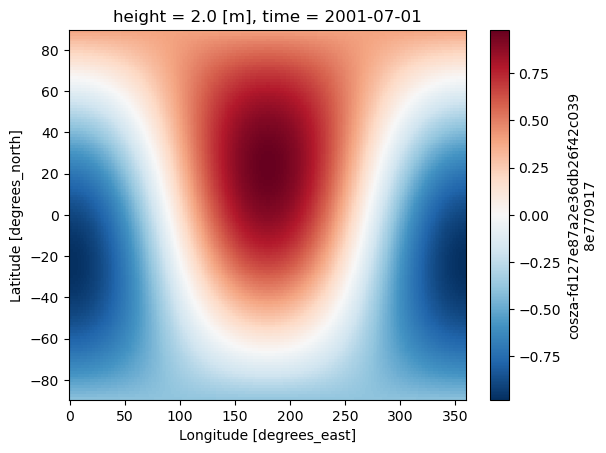

In [14]:
cza[0,:,:].plot()

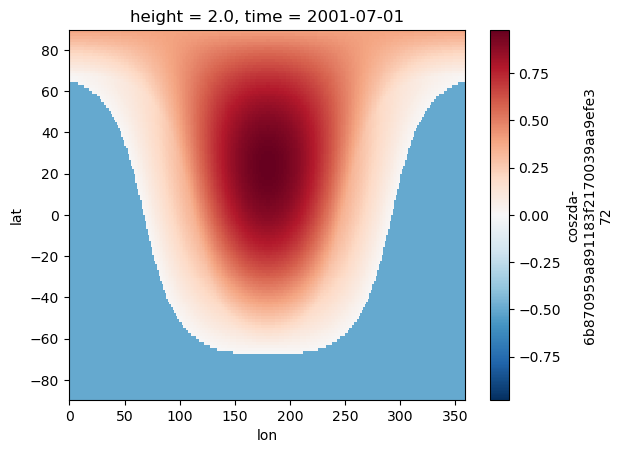

In [15]:
czda[0,:,:].plot()

### 3.3 Calculate vapor pressure
Here we calculate vapor pressure from specific humidity since vapor pressure is one of the required inputs for WBGT function.

In [16]:
# calculate vapor pressure
def vaporpres(huss, ps):
    # huss: specific humidity (kg/kg)
    # ps: surface pressure (Pa)
    # return vapor pressure (Pa)
    r=huss*((1-huss)**(-1))
    return ps*r*((0.622+r)**(-1))


In [17]:
# calculate vapor pressure
ea=xr.apply_ufunc(vaporpres,huss,ps,dask="parallelized",output_dtypes=[float])

### 3.4 Calculate 2m wind speed
Calculate wind speed from the u and v components of wind. Keep in mind that CMIP6 wind speed are output at 10m height and needs to be converted to 2m

In [18]:
func = lambda x, y: np.sqrt(x ** 2 + y ** 2)
wind10m=xr.apply_ufunc(func, uas, vas,dask="parallelized",output_dtypes=[float])
wind2m=xr.apply_ufunc(WBGT_analytic.getwind2m,wind10m,czda,rsdsinterp,dask="parallelized",output_dtypes=[float])

### 3.5 Calculate the ratio of direct solar radiation
We need to know the ratio of direct solar radiation in order to get the radiation heat gain right for WBGT calculation, since the treatment of direct and diffuse solar radiation are different in the code. 

In this case, we have ```rsdsdiff``` which is the diffuse solar radiation, so we can directly calculate the ratio of direct solar radiation. 

When we don't have such a field, we need to call the **```fdir```** function (also can be imported from the ```WBGT_analytic``` module) to calculate the ratio. Please refer to the ```WBGT_analytic.py``` file for how to call **```fdir```** function.

In [19]:
f=(rsdsinterp-rsdsdiffinterp)/rsdsinterp 
# the treatments below aim to avoid unrealistically high or low values of f which are also included in Liljegren's code.
f=xr.where(cza<=np.cos(89.5/180*np.pi),0,f) 
f=xr.where(f>0.9,0.9,f)
f=xr.where(f<0,0,f)
f=xr.where(rsdsinterp<=0,0,f)

# 4. Calculate WBGT

In [20]:
# natural wet-bulb temperature
Tnw=xr.apply_ufunc(WBGT_analytic.calc_Tnw,tas,ea,ps,wind2m,czda,rsdsinterp,rldsinterp,rsusinterp,rlusinterp,f,dask="parallelized",output_dtypes=[float])
# black globe temperature
Tg=xr.apply_ufunc(WBGT_analytic.calc_Tg,tas,ps,wind2m,czda,rsdsinterp,rldsinterp,rsusinterp,rlusinterp,f,dask="parallelized",output_dtypes=[float])
# wet-bulb globe temperature
WBGT=xr.apply_ufunc(WBGT_analytic.calc_WBGT,tas,ea,ps,wind2m,czda,rsdsinterp,rldsinterp,rsusinterp,rlusinterp,f,dask="parallelized",output_dtypes=[float])

Let's plot calculated WBGT at the last time step

/home/kong97/miniconda3/envs/qin/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


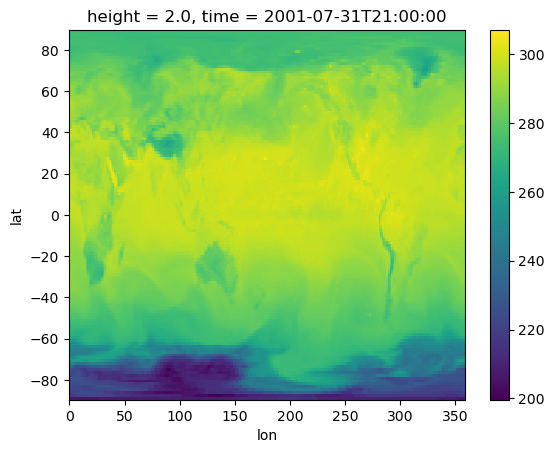

In [21]:
WBGT[-1,:,:].plot()

# References
Liljegren, J. C., Carhart, R. A., Lawday, P., Tschopp, S. & Sharp, R. Modeling the Wet Bulb Globe Temperature Using Standard Meteorological Measurements. Journal of Occupational and Environmental Hygiene 5, 645–655 (2008).

Di Napoli, C., Hogan, R. J. & Pappenberger, F. Mean radiant temperature from global-scale numerical weather prediction models. Int J Biometeorol 64, 1233–1245 (2020).

Hogan, R. J. & Hirahara, S. Effect of solar zenith angle specification in models on mean shortwave fluxes and stratospheric temperatures. Geophys. Res. Lett. 43, 482–488 (2016).

Kong, Q. & Huber, M. Explicit calculations of Wet Bulb Globe Temperature compared with approximations and why it matters for labor productivity. Earth’s Future (2022) doi:10.1029/2021EF002334.

